In [110]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
%autoreload 2

In [112]:
from lib import sim_env as sim
from lib import loads
from lib.utils import (DTManager, adjust_db_dates_local_tz)
from lib import agents
import datetime

# environment
dt = current_time_tz(cut_microseconds=True)
env = sim.SimulationEnvironment(name='base', time_unit='seconds', starting_datetime=dt)
job_generator = loads.RandomJobGenerator(seed=2)
infstruct_mgr = sim.InfrastructureManager(env=env)
dispatcher = sim.Dispatcher(env=env, priority_rule='FIFO')

# source
area_source = sim.ProductionArea(env=env, custom_identifier=1000)
group_source = sim.StationGroup(env=env, custom_identifier=1000)
area_source.add_subsystem(group_source)
proc_time = dt_parser.timedelta_from_val(val=2., time_unit='hours')
source = sim.Source(env=env, custom_identifier='source', proc_time=proc_time, 
                random_generation=True, job_generator=job_generator, num_gen_jobs=5)
group_source.add_subsystem(source)

# sink
area_sink = sim.ProductionArea(env=env, custom_identifier=2000)
group_sink = sim.StationGroup(env=env, custom_identifier=2000)
area_sink.add_subsystem(group_sink)
sink = sim.Sink(env=env, custom_identifier='sink')
group_sink.add_subsystem(sink)

# processing stations
# prod area 1
area_prod = sim.ProductionArea(env=env, custom_identifier=1)
group_prod = sim.StationGroup(env=env, custom_identifier=1)
area_prod.add_subsystem(group_prod)
group_prod2 = sim.StationGroup(env=env, custom_identifier=2)
area_prod.add_subsystem(group_prod2)
# prod area 2
#area_prod2 = ProductionArea(env=env, custom_identifier=2)
#group_prod3 = StationGroup(env=env, custom_identifier=3)
#area_prod2.add_subsystem(group_prod3)
#area_prod.add_subsystem(group_prod3)
## machines
for machine in range(3):
    buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine))
    if machine == 5:
        MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer], setup_time=5.)
    else:
        MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer])
        
    if machine == 0:
        testMachInst = MachInst
    
    if machine < 2:
        group_prod.add_subsystem(buffer)
        group_prod.add_subsystem(MachInst)
    elif machine >= 2:
        group_prod2.add_subsystem(buffer)
        group_prod2.add_subsystem(MachInst)
    else:
        pass
        #group_prod3.add_subsystem(buffer)
        #group_prod3.add_subsystem(MachInst)
    

add_machine_to_bottleneck: bool = False
if add_machine_to_bottleneck:
    buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine+1))
    MachInst = sim.Machine(env=env, custom_identifier=machine+1, buffers=[buffer])
    group_prod3.add_subsystem(buffer)
    group_prod3.add_subsystem(MachInst)

alloc_agent = agents.AllocationAgent(assoc_system=area_prod)

alloc_agent._assoc_infstrct_objs

# station group IDs (system, custom) for processing stations
MachInst.supersystems_custom_ids

In [134]:
# datetime manager
dt_mgr = DTManager()
starting_dt = dt_mgr.current_time_tz(cut_microseconds=True)
# environment
env = sim.SimulationEnvironment(name='base', time_unit='seconds', starting_datetime=starting_dt)
infstruct_mgr = sim.InfrastructureManager(env=env)
dispatcher = sim.Dispatcher(env=env, priority_rule='FIFO')
proc_time = dt_mgr.timedelta_from_val(val=2., time_unit='hours')
job_generator = loads.RandomJobGenerator(seed=2)
source = sim.Source(env=env, custom_identifier='source', proc_time=proc_time, 
                    random_generation=True, job_generator=job_generator, num_gen_jobs=8)
sim_dur = dt_mgr.timedelta_from_val(val=2., time_unit='days')
job_gen_dur_cond = sim.JobGenDurationCondition(env=env, target_obj=source, sim_run_duration=sim_dur)

INFO:sim_env.env:Successfully registered Infrastructure Manager in Env >>base<<
INFO:sim_env.env:Successfully registered Dispatcher in Env >>base<<
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name Source_env_0


dt_mgr = DTManager()
dt_mgr.dt_with_tz_UTC(2024,3,23,12)

In [297]:
def build_sim_env() -> tuple[
    sim.SimulationEnvironment,
    sim.InfrastructureManager,
    sim.Dispatcher,
    agents.AllocationAgent,
]:
    # !! REWORK, CURRENTLY ONLY FOR TESTING PURPOSES
    """Constructor to build simulation environment (layout)

    Returns
    -------
    tuple[ sim.SimulationEnvironment, sim.InfrastructureManager, sim.Dispatcher, agents.AllocationAgent, ]
        tuple out of Environment, InfrastructureManager, Dispatcher, Agent
    """
    # datetime manager
    dt_mgr = DTManager()
    starting_dt = dt_mgr.current_time_tz(cut_microseconds=True)
    # environment
    env = sim.SimulationEnvironment(name='base', time_unit='seconds', starting_datetime=starting_dt)
    job_generator = loads.RandomJobGenerator(seed=100)
    infstruct_mgr = sim.InfrastructureManager(env=env)
    dispatcher = sim.Dispatcher(env=env, priority_rule='FIFO')
    
    # source
    area_source = sim.ProductionArea(env=env, custom_identifier=1000)
    group_source = sim.StationGroup(env=env, custom_identifier=1000)
    area_source.add_subsystem(group_source)
    proc_time = dt_mgr.timedelta_from_val(val=2., time_unit='hours')
    source = sim.Source(env=env, custom_identifier='source', proc_time=proc_time, 
                    random_generation=True, job_generator=job_generator, num_gen_jobs=12)
    group_source.add_subsystem(source)

    # sink
    area_sink = sim.ProductionArea(env=env, custom_identifier=2000)
    group_sink = sim.StationGroup(env=env, custom_identifier=2000)
    area_sink.add_subsystem(group_sink)
    sink = sim.Sink(env=env, custom_identifier='sink')
    group_sink.add_subsystem(sink)

    # processing stations
    # prod area 1
    area_prod = sim.ProductionArea(env=env, custom_identifier=1)
    group_prod = sim.StationGroup(env=env, custom_identifier=1)
    area_prod.add_subsystem(group_prod)
    group_prod2 = sim.StationGroup(env=env, custom_identifier=2)
    area_prod.add_subsystem(group_prod2)
    # prod area 2
    #area_prod2 = ProductionArea(env=env, custom_identifier=2)
    #group_prod3 = StationGroup(env=env, custom_identifier=3)
    #area_prod2.add_subsystem(group_prod3)
    #area_prod.add_subsystem(group_prod3)
    ## machines
    for machine in range(3):
        buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine))
        if machine == 5:
            MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer], setup_time=5.)
        else:
            MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer])
            
        if machine == 0:
            testMachInst = MachInst
        
        if machine < 2:
            group_prod.add_subsystem(buffer)
            group_prod.add_subsystem(MachInst)
        elif machine >= 2:
            group_prod2.add_subsystem(buffer)
            group_prod2.add_subsystem(MachInst)
        else:
            pass
            #group_prod3.add_subsystem(buffer)
            #group_prod3.add_subsystem(MachInst)
        

    add_machine_to_bottleneck: bool = False
    if add_machine_to_bottleneck:
        buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine+1))
        MachInst = sim.Machine(env=env, custom_identifier=machine+1, buffers=[buffer])
        group_prod3.add_subsystem(buffer)
        group_prod3.add_subsystem(MachInst)
        
    alloc_agent = agents.AllocationAgent(assoc_system=area_prod)

    # conditions
    duration_transient = dt_mgr.timedelta_from_val(val=2, time_unit='hours')
    trans_cond = sim.TransientCondition(env=env, duration_transient=duration_transient)
    agent_decision_cond = sim.TriggerAgentCondition(env=env)
    sim_dur = dt_mgr.timedelta_from_val(val=2., time_unit='days')
    sim_end_date = dt_mgr.dt_with_tz_UTC(2024,3,23,12)
    job_gen_dur_cond = sim.JobGenDurationCondition(env=env, target_obj=source, sim_run_duration=sim_dur)
    
    return env, infstruct_mgr, dispatcher, alloc_agent

In [298]:
(env, infstruct_mgr, dispatcher, agent) = build_sim_env()

INFO:sim_env.env:Successfully registered Infrastructure Manager in Env >>base<<
INFO:sim_env.env:Successfully registered Dispatcher in Env >>base<<
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name ProductionArea_env_0
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name StationGroup_env_0
INFO:sim_env.infstrct:Successfully added System (type: StationGroup, custom_id: 1000, name: StationGroup_env_0) to System (type: ProductionArea, custom_id: 1000, name: ProductionArea_env_0).
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name Source_env_0
INFO:sim_env.infstrct:Successfully added System (type: Resource, custom_id: source, name: Source_env_0) to System (type: StationGroup, custom_id: 1000, name: StationGroup_env_0).
INFO:sim_env.infstrct:Successfully registered object with SystemID 1 and name ProductionArea_env_1
INFO:sim_env.infstrct:Successfully registered object with SystemID 1 and name StationGroup_env_1

In [299]:
infstruct_mgr.prod_area_db

,custom_id,name,prod_area,containing_proc_stations
prod_area_id,,,,
0,1000,ProductionArea_env_0,{0: {0: {}}},False
1,2000,ProductionArea_env_1,{1: {1: {}}},False
2,1,ProductionArea_env_2,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",True


In [300]:
infstruct_mgr.station_group_db

,custom_id,name,station_group,prod_area_id,containing_proc_stations
station_group_id,,,,,
0,1000,StationGroup_env_0,{0: {}},0,False
1,2000,StationGroup_env_1,{1: {}},1,False
2,1,StationGroup_env_2,"{2: {}, 3: {}, 4: {}, 5: {}}",2,True
3,2,StationGroup_env_3,"{6: {}, 7: {}}",2,True


In [301]:
infstruct_mgr.res_db

,custom_id,resource,name,res_type,state,station_group_id
res_id,,,,,,
0,source,{},Source_env_0,Source,INIT,0
1,sink,{},Sink_env_1,Sink,INIT,1
2,10,{},Buffer_env_2,Buffer,INIT,2
3,0,{},Machine_env_3,Machine,INIT,2
4,11,{},Buffer_env_4,Buffer,INIT,2
5,1,{},Machine_env_5,Machine,INIT,2
6,12,{},Buffer_env_6,Buffer,INIT,3
7,2,{},Machine_env_7,Machine,INIT,3


In [302]:
env.check_integrity()

INFO:sim_env.env:Integrity check for Environment base successful.


In [303]:
print('Prio Rules:', dispatcher.possible_prio_rules())
print('Alloc Rules:', dispatcher.possible_alloc_rules())

Prio Rules: {'LIFO', 'LST', 'PRIO', 'SST', 'LPT', 'SPT', 'FIFO'}
Alloc Rules: {'AGENT', 'WIP_LOAD_TIME', 'UTILISATION', 'RANDOM', 'WIP_LOAD_JOBS'}


In [304]:
dispatcher.curr_prio_rule = 'LPT'
dispatcher.curr_alloc_rule = 'WIP_LOAD_TIME'
#dispatcher.curr_alloc_rule = 'AGENT'

In [305]:
agent.assoc_proc_stations

(System (type: Resource, custom_id: 0, name: Machine_env_3),
 System (type: Resource, custom_id: 1, name: Machine_env_5),
 System (type: Resource, custom_id: 2, name: Machine_env_7))

**Sequential run**

In [306]:
agent.dispatching_signal

False

In [307]:
env.initialise()

INFO:sim_env.env:Initialisation for Environment base successful.


In [342]:
## second block in step function
## execute with provided action till next decision should be made
while not agent.dispatching_signal:
    #if env.sim_ended:
        #break
    # empty event list, simulation run ended
    if not env._event_list:
        break
    env.step()
    #print(f'Env Trans State: {env.is_transient_cond}')


## third block
## calculate reward before next decision is made
agent.calc_reward()

 
## first block in step function
## action is provided as parameter
## set action
# if still events left, get/set action
#if env._event_list and not env.is_transient_cond:
if env._event_list:
    print('Dispatching Signal', agent.dispatching_signal)
    action = agent.random_action()
    agent.set_decision(action=action)
else:
    print('Run ended!')

DEBUG:agents.agents:++++++ stations=(System (type: Resource, custom_id: 2, name: Machine_env_7),)
DEBUG:agents.agents:++++++ util_vals=[0.09090909090909091]
DEBUG:agents.agents:++++++ util_mean=0.09090909090909091
DEBUG:agents.agents:+#+#+#+#+# reward=50.0
Run ended!


**Customised Salabim:**
- added ``self.end_on_empty_eventlist`` as this attribute was not available, but used internally in Salabim
- ~~added ``sim_ended`` to indicate if run was finished or~~ use ``_event_list``

**Needed Features:**
- condition monitor to set flags

In [343]:
agent.current_job

Job (J_gen_11)

In [344]:
agent.last_job

Job (J_gen_10)

In [345]:
agent.current_op

Operation(ProcTime: 6:00:00, ExecutionSystemID: 1, SGI: 2)

In [346]:
agent.last_op.target_station_group_identifier

2

In [347]:
agent.last_job.operations

deque([Operation(ProcTime: 6:00:00, ExecutionSystemID: 1, SGI: 2)])

In [348]:
agent.current_job.operations

deque([Operation(ProcTime: 6:00:00, ExecutionSystemID: 1, SGI: 2)])

In [349]:
env.finalise()

INFO:sim_env.infstrct:Successful finalisation of the state information for all resource objects.


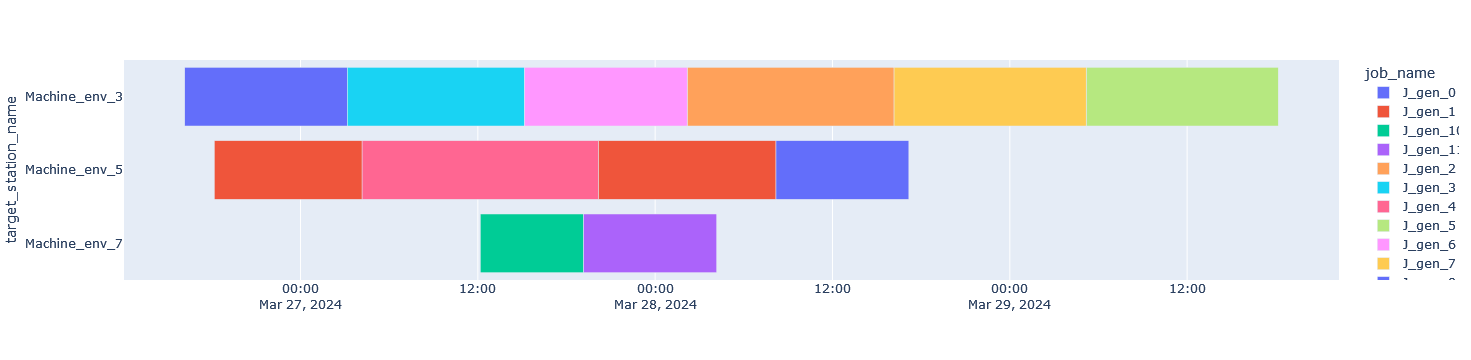

In [350]:
fig = dispatcher.draw_gantt_chart(dates_to_local_tz=True, use_custom_proc_station_id=False)

In [200]:
agent.assoc_proc_stations[1].stat_monitor.utilisation

0.3888888888888889

In [108]:
agent.assoc_proc_stations[2].custom_identifier

2

In [195]:
dispatcher.op_db.to_excel('test.xlsx')

ValueError: Excel does not support datetimes with timezones. Please ensure that datetimes are timezone unaware before writing to Excel.

**Complete run**

In [284]:
def build_sim_env_run_once() -> tuple[
    sim.SimulationEnvironment,
    sim.InfrastructureManager,
    sim.Dispatcher,
    agents.AllocationAgent,
]:
    # !! REWORK, CURRENTLY ONLY FOR TESTING PURPOSES
    """Constructor to build simulation environment (layout)

    Returns
    -------
    tuple[ sim.SimulationEnvironment, sim.InfrastructureManager, sim.Dispatcher, agents.AllocationAgent, ]
        tuple out of Environment, InfrastructureManager, Dispatcher, Agent
    """
    # datetime manager
    dt_mgr = DTManager()
    starting_dt = dt_mgr.current_time_tz(cut_microseconds=True)
    # environment
    env = sim.SimulationEnvironment(name='base', time_unit='seconds', starting_datetime=starting_dt)
    job_generator = loads.RandomJobGenerator(seed=100)
    infstruct_mgr = sim.InfrastructureManager(env=env)
    dispatcher = sim.Dispatcher(env=env, priority_rule='FIFO')
    
    # source
    area_source = sim.ProductionArea(env=env, custom_identifier=1000)
    group_source = sim.StationGroup(env=env, custom_identifier=1000)
    area_source.add_subsystem(group_source)
    proc_time = dt_mgr.timedelta_from_val(val=2., time_unit='hours')
    source = sim.Source(env=env, custom_identifier='source', proc_time=proc_time, 
                    random_generation=True, job_generator=job_generator, num_gen_jobs=12)
    group_source.add_subsystem(source)

    # sink
    area_sink = sim.ProductionArea(env=env, custom_identifier=2000)
    group_sink = sim.StationGroup(env=env, custom_identifier=2000)
    area_sink.add_subsystem(group_sink)
    sink = sim.Sink(env=env, custom_identifier='sink')
    group_sink.add_subsystem(sink)

    # processing stations
    # prod area 1
    area_prod = sim.ProductionArea(env=env, custom_identifier=1)
    group_prod = sim.StationGroup(env=env, custom_identifier=1)
    area_prod.add_subsystem(group_prod)
    group_prod2 = sim.StationGroup(env=env, custom_identifier=2)
    area_prod.add_subsystem(group_prod2)
    # prod area 2
    #area_prod2 = ProductionArea(env=env, custom_identifier=2)
    #group_prod3 = StationGroup(env=env, custom_identifier=3)
    #area_prod2.add_subsystem(group_prod3)
    #area_prod.add_subsystem(group_prod3)
    ## machines
    for machine in range(3):
        buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine))
        if machine == 5:
            MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer], setup_time=5.)
        else:
            MachInst = sim.Machine(env=env, custom_identifier=machine, buffers=[buffer])
            
        if machine == 0:
            testMachInst = MachInst
        
        if machine < 2:
            group_prod.add_subsystem(buffer)
            group_prod.add_subsystem(MachInst)
        elif machine >= 2:
            group_prod2.add_subsystem(buffer)
            group_prod2.add_subsystem(MachInst)
        else:
            pass
            #group_prod3.add_subsystem(buffer)
            #group_prod3.add_subsystem(MachInst)
        

    add_machine_to_bottleneck: bool = False
    if add_machine_to_bottleneck:
        buffer = sim.Buffer(capacity=20, env=env, custom_identifier=(10+machine+1))
        MachInst = sim.Machine(env=env, custom_identifier=machine+1, buffers=[buffer])
        group_prod3.add_subsystem(buffer)
        group_prod3.add_subsystem(MachInst)
        
    alloc_agent = agents.AllocationAgent(assoc_system=area_prod)

    # conditions
    duration_transient = dt_mgr.timedelta_from_val(val=2, time_unit='hours')
    trans_cond = sim.TransientCondition(env=env, duration_transient=duration_transient)
    #agent_decision_cond = sim.TriggerAgentCondition(env=env)
    sim_dur = dt_mgr.timedelta_from_val(val=2., time_unit='days')
    sim_end_date = dt_mgr.dt_with_tz_UTC(2024,3,23,12)
    job_gen_dur_cond = sim.JobGenDurationCondition(env=env, target_obj=source, sim_run_duration=sim_dur)
    
    return env, infstruct_mgr, dispatcher, alloc_agent

In [285]:
(env, infstruct_mgr, dispatcher, agent) = build_sim_env_run_once()

INFO:sim_env.env:Successfully registered Infrastructure Manager in Env >>base<<
INFO:sim_env.env:Successfully registered Dispatcher in Env >>base<<
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name ProductionArea_env_0
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name StationGroup_env_0
INFO:sim_env.infstrct:Successfully added System (type: StationGroup, custom_id: 1000, name: StationGroup_env_0) to System (type: ProductionArea, custom_id: 1000, name: ProductionArea_env_0).
INFO:sim_env.infstrct:Successfully registered object with SystemID 0 and name Source_env_0
INFO:sim_env.infstrct:Successfully added System (type: Resource, custom_id: source, name: Source_env_0) to System (type: StationGroup, custom_id: 1000, name: StationGroup_env_0).
INFO:sim_env.infstrct:Successfully registered object with SystemID 1 and name ProductionArea_env_1
INFO:sim_env.infstrct:Successfully registered object with SystemID 1 and name StationGroup_env_1

In [286]:
env.initialise()

INFO:sim_env.env:Initialisation for Environment base successful.


In [287]:
env.run()

DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] Stat Group IDs: {1: [1, 2]}
DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] ProcTimes [datetime.timedelta(seconds=25200)] at 0.0
DEBUG:sim_env.sources:job_ex_order=[1]
DEBUG:sim_env.sources:job_target_station_groups=[1]
DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] Job target station group System (type: StationGroup, custom_id: 1, name: StationGroup_env_2)
DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] Generated Job (J_gen_0) at 0.0
DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] Request allocation...
DEBUG:sim_env.sources:[SOURCE: System (type: Resource, custom_id: source, name: Source_env_0)] PUT JOB with ret = System (type: Resource, custom_id: 1, name: Machine_env_5)
DEBUG:sim_env.sources:[SOURCE: Sys

In [288]:
env.finalise()

INFO:sim_env.infstrct:Successful finalisation of the state information for all resource objects.


In [289]:
dispatcher.op_db.head()

,job_id,job_name,custom_id,op,name,prio,execution_system,execution_system_custom_id,execution_system_name,execution_system_type,...,creation_date,release_date,planned_starting_date,actual_starting_date,starting_date_deviation,planned_ending_date,actual_ending_date,ending_date_deviation,lead_time,state
op_id,,,,,,,,,,,,,,,,,,,,,
0,0,J_gen_0,None,"Operation(ProcTime: 7:00:00, ExecutionSystemID...",O_gen_0,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 15:09:31+00:00,2024-03-26 15:09:31+00:00,None,2024-03-26 15:09:31+00:00,None,None,2024-03-27 02:09:31+00:00,None,11:00:00,FINISH
1,1,J_gen_1,None,"Operation(ProcTime: 8:00:00, ExecutionSystemID...",O_gen_1,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 17:09:31+00:00,2024-03-26 17:09:31+00:00,None,2024-03-26 17:09:31+00:00,None,None,2024-03-27 03:09:31+00:00,None,10:00:00,FINISH
2,2,J_gen_2,None,"Operation(ProcTime: 6:00:00, ExecutionSystemID...",O_gen_2,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 19:09:31+00:00,2024-03-26 19:09:31+00:00,None,2024-03-27 02:09:31+00:00,None,None,2024-03-27 16:09:31+00:00,None,21:00:00,FINISH
3,3,J_gen_3,None,"Operation(ProcTime: 7:00:00, ExecutionSystemID...",O_gen_3,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 21:09:31+00:00,2024-03-26 21:09:31+00:00,None,2024-03-27 03:09:31+00:00,None,None,2024-03-27 15:09:31+00:00,None,18:00:00,FINISH
4,4,J_gen_4,None,"Operation(ProcTime: 9:00:00, ExecutionSystemID...",O_gen_4,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 23:09:31+00:00,2024-03-26 23:09:31+00:00,None,2024-03-27 15:09:31+00:00,None,None,2024-03-28 07:09:31+00:00,None,"1 day, 8:00:00",FINISH


In [290]:
dispatcher.op_db.columns

Index(['job_id', 'job_name', 'custom_id', 'op', 'name', 'prio',
       'execution_system', 'execution_system_custom_id',
       'execution_system_name', 'execution_system_type',
       'target_station_custom_id', 'target_station_name', 'proc_time',
       'setup_time', 'order_time', 'creation_date', 'release_date',
       'planned_starting_date', 'actual_starting_date',
       'starting_date_deviation', 'planned_ending_date', 'actual_ending_date',
       'ending_date_deviation', 'lead_time', 'state'],
      dtype='object')

In [291]:
dispatcher.job_db

,custom_id,job,name,job_type,prio,total_proc_time,creation_date,release_date,planned_starting_date,actual_starting_date,starting_date_deviation,planned_ending_date,actual_ending_date,ending_date_deviation,lead_time,state
job_id,,,,,,,,,,,,,,,,
0,None,Job (J_gen_0),J_gen_0,Job,1,0 days 07:00:00,2024-03-26 15:09:31+00:00,2024-03-26 15:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-26 15:09:31+00:00,"127 days, 9:09:31",2023-12-01 10:00:00+00:00,2024-03-27 02:09:31+00:00,"116 days, 16:09:31",11:00:00,FINISH
1,None,Job (J_gen_1),J_gen_1,Job,4,0 days 08:00:00,2024-03-26 17:09:31+00:00,2024-03-26 17:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-26 17:09:31+00:00,"127 days, 11:09:31",2023-12-01 10:00:00+00:00,2024-03-27 03:09:31+00:00,"116 days, 17:09:31",10:00:00,FINISH
2,None,Job (J_gen_2),J_gen_2,Job,7,0 days 06:00:00,2024-03-26 19:09:31+00:00,2024-03-26 19:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 02:09:31+00:00,"127 days, 20:09:31",2023-12-01 10:00:00+00:00,2024-03-27 16:09:31+00:00,"117 days, 6:09:31",21:00:00,FINISH
3,None,Job (J_gen_3),J_gen_3,Job,8,0 days 07:00:00,2024-03-26 21:09:31+00:00,2024-03-26 21:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 03:09:31+00:00,"127 days, 21:09:31",2023-12-01 10:00:00+00:00,2024-03-27 15:09:31+00:00,"117 days, 5:09:31",18:00:00,FINISH
4,None,Job (J_gen_4),J_gen_4,Job,12,0 days 09:00:00,2024-03-26 23:09:31+00:00,2024-03-26 23:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 15:09:31+00:00,"128 days, 9:09:31",2023-12-01 10:00:00+00:00,2024-03-28 07:09:31+00:00,"117 days, 21:09:31","1 day, 8:00:00",FINISH
5,None,Job (J_gen_5),J_gen_5,Job,11,0 days 05:00:00,2024-03-27 01:09:31+00:00,2024-03-27 01:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-28 07:09:31+00:00,"129 days, 1:09:31",2023-12-01 10:00:00+00:00,2024-03-28 20:09:31+00:00,"118 days, 10:09:31","1 day, 19:00:00",FINISH
6,None,Job (J_gen_6),J_gen_6,Job,11,0 days 08:00:00,2024-03-27 03:09:31+00:00,2024-03-27 03:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 03:09:31+00:00,"127 days, 21:09:31",2023-12-01 10:00:00+00:00,2024-03-27 14:09:31+00:00,"117 days, 4:09:31",11:00:00,FINISH
7,None,Job (J_gen_7),J_gen_7,Job,10,0 days 06:00:00,2024-03-27 05:09:31+00:00,2024-03-27 05:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 16:09:31+00:00,"128 days, 10:09:31",2023-12-01 10:00:00+00:00,2024-03-28 05:09:31+00:00,"117 days, 19:09:31","1 day, 0:00:00",FINISH
8,None,Job (J_gen_8),J_gen_8,Job,10,0 days 08:00:00,2024-03-27 07:09:31+00:00,2024-03-27 07:09:31+00:00,2023-11-20 06:00:00+00:00,2024-03-27 14:09:31+00:00,"128 days, 8:09:31",2023-12-01 10:00:00+00:00,2024-03-27 23:09:31+00:00,"117 days, 13:09:31",16:00:00,FINISH


In [292]:
dispatcher._op_db_date_adjusted

,job_id,job_name,custom_id,op,name,prio,execution_system,execution_system_custom_id,execution_system_name,execution_system_type,...,creation_date,release_date,planned_starting_date,actual_starting_date,starting_date_deviation,planned_ending_date,actual_ending_date,ending_date_deviation,lead_time,state
op_id,,,,,,,,,,,,,,,,,,,,,
0,0,J_gen_0,None,"Operation(ProcTime: 7:00:00, ExecutionSystemID...",O_gen_0,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 16:09:31+01:00,2024-03-26 16:09:31+01:00,None,2024-03-26 16:09:31+01:00,None,None,2024-03-27 03:09:31+01:00,None,11:00:00,FINISH
1,1,J_gen_1,None,"Operation(ProcTime: 8:00:00, ExecutionSystemID...",O_gen_1,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 18:09:31+01:00,2024-03-26 18:09:31+01:00,None,2024-03-26 18:09:31+01:00,None,None,2024-03-27 04:09:31+01:00,None,10:00:00,FINISH
2,2,J_gen_2,None,"Operation(ProcTime: 6:00:00, ExecutionSystemID...",O_gen_2,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 20:09:31+01:00,2024-03-26 20:09:31+01:00,None,2024-03-27 03:09:31+01:00,None,None,2024-03-27 17:09:31+01:00,None,21:00:00,FINISH
3,3,J_gen_3,None,"Operation(ProcTime: 7:00:00, ExecutionSystemID...",O_gen_3,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-26 22:09:31+01:00,2024-03-26 22:09:31+01:00,None,2024-03-27 04:09:31+01:00,None,None,2024-03-27 16:09:31+01:00,None,18:00:00,FINISH
4,4,J_gen_4,None,"Operation(ProcTime: 9:00:00, ExecutionSystemID...",O_gen_4,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-27 00:09:31+01:00,2024-03-27 00:09:31+01:00,None,2024-03-27 16:09:31+01:00,None,None,2024-03-28 08:09:31+01:00,None,"1 day, 8:00:00",FINISH
5,5,J_gen_5,None,"Operation(ProcTime: 5:00:00, ExecutionSystemID...",O_gen_5,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-27 02:09:31+01:00,2024-03-27 02:09:31+01:00,None,2024-03-28 08:09:31+01:00,None,None,2024-03-28 21:09:31+01:00,None,"1 day, 19:00:00",FINISH
6,6,J_gen_6,None,"Operation(ProcTime: 8:00:00, ExecutionSystemID...",O_gen_6,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-27 04:09:31+01:00,2024-03-27 04:09:31+01:00,None,2024-03-27 04:09:31+01:00,None,None,2024-03-27 15:09:31+01:00,None,11:00:00,FINISH
7,7,J_gen_7,None,"Operation(ProcTime: 6:00:00, ExecutionSystemID...",O_gen_7,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-27 06:09:31+01:00,2024-03-27 06:09:31+01:00,None,2024-03-27 17:09:31+01:00,None,None,2024-03-28 06:09:31+01:00,None,"1 day, 0:00:00",FINISH
8,8,J_gen_8,None,"Operation(ProcTime: 8:00:00, ExecutionSystemID...",O_gen_8,None,"{2: {2: {}, 3: {}, 4: {}, 5: {}}, 3: {6: {}, 7...",1,<bound method System.name of System (type: Pro...,ProductionArea,...,2024-03-27 08:09:31+01:00,2024-03-27 08:09:31+01:00,None,2024-03-27 15:09:31+01:00,None,None,2024-03-28 00:09:31+01:00,None,16:00:00,FINISH


In [293]:
job = dispatcher.get_job_obj_by_prop(val=2)

In [294]:
job.stat_monitor.state_durations

,abs [Timedelta],abs [seconds],rel [%]
BLOCKED,0 days 00:00:00,0.0,0.000000
FAILED,0 days 00:00:00,0.0,0.000000
PAUSED,0 days 00:00:00,0.0,0.000000
PROCESSING,0 days 06:00:00,21600.0,28.571429
SETUP,0 days 08:00:00,28800.0,38.095238
WAITING,0 days 07:00:00,25200.0,33.333333


In [295]:
job.operations[0].stat_monitor.state_durations

,abs [Timedelta],abs [seconds],rel [%]
BLOCKED,0 days 00:00:00,0.0,0.000000
FAILED,0 days 00:00:00,0.0,0.000000
PAUSED,0 days 00:00:00,0.0,0.000000
PROCESSING,0 days 06:00:00,21600.0,28.571429
SETUP,0 days 08:00:00,28800.0,38.095238
WAITING,0 days 07:00:00,25200.0,33.333333


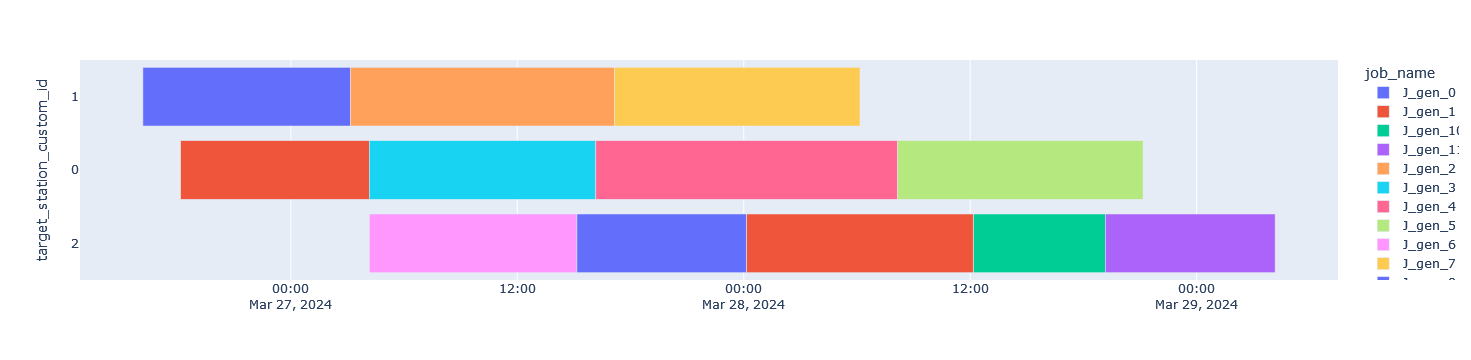

In [296]:
fig = dispatcher.draw_gantt_chart(dates_to_local_tz=True)